In [1]:
# ==========================================
# Portefeuille centré Nintendo - version interactive (débutant)
# ==========================================
# - Nintendo imposée
# - Poids de Nintendo FIXE choisi par l'utilisateur
# - Affichage avec noms d'entreprises (pas les tickers)
# - Tri croissant des allocations + même ordre sur le graphe
# - Suggestion de poids Nintendo si la cible n'est pas atteinte
# - BOUCLE : on rejoue la simulation tant que l'investisseur répond OUI
# ==========================================

from __future__ import annotations
import warnings
from dataclasses import dataclass
from typing import List

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# cvxpy optionnel (QP). Fallback prévu si absent.
try:
    import cvxpy as cp
    HAS_CVXPY = True
except Exception:
    HAS_CVXPY = False

warnings.filterwarnings("ignore")

# -------------------------------------
# Config de base
# -------------------------------------
NINTENDO = "NTDOY"  # Nintendo imposée (ADR US)
DEFAULT_PEERS = ["EA", "TTWO", "SONY", "MSFT", "7832.T", "9697.T", "9684.T", "9766.T", "UBI.PA", "TCEHY"]
START, END = "2015-09-30", "2025-09-30"

TICKER_NAME = {
    "NTDOY": "Nintendo (ADR)",
    "7974.T": "Nintendo (Tokyo)",
    "EA": "Electronic Arts",
    "TTWO": "Take-Two Interactive",
    "SONY": "Sony Group (ADR)",
    "MSFT": "Microsoft",
    "7832.T": "Bandai Namco",
    "9697.T": "Capcom",
    "9684.T": "Square Enix",
    "9766.T": "Konami",
    "UBI.PA": "Ubisoft",
    "TCEHY": "Tencent (ADR)",
}

ORDER = "asc"  # tri des allocations


# -------------------------------------
# Fonctions d'entrée utilisateur
# -------------------------------------
def ask_float_pct(msg: str, default: float, lo: float = 0.0, hi: float = 1.0) -> float:
    """Demande un pourcentage lisible (6, 6%, 0.06). Renvoie un float dans [0..1]."""
    while True:
        s = input(f"{msg} [{int(default*100)}%]: ").strip().lower()
        if not s:
            return default
        try:
            s = s.replace(",", ".")
            if s.endswith("%"):
                x = float(s[:-1]) / 100
            else:
                x = float(s)
                if x > 1:
                    x = x / 100
        except ValueError:
            print("→ Merci d'entrer un nombre (ex: 6, 6%, 0.06).")
            continue
        if lo <= x <= hi:
            return x
        print(f"→ Le pourcentage doit être entre {lo:.0%} et {hi:.0%}.")


def ask_int(msg: str, default: int, lo: int = 1, hi: int = 20) -> int:
    """Demande un entier (ex: années)."""
    while True:
        s = input(f"{msg} [{default}]: ").strip()
        if not s:
            return default
        if s.isdigit():
            x = int(s)
            if lo <= x <= hi:
                return x
        print(f"→ Entrer un entier entre {lo} et {hi}.")


# -------------------------------------
# Données Yahoo & métriques
# -------------------------------------
def download_prices(tickers: List[str], start: str, end: str) -> pd.DataFrame:
    data = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=True)
    if isinstance(data.columns, pd.MultiIndex):
        data = data["Close"]
    return data.ffill().dropna()


def pct_returns(prices: pd.DataFrame) -> pd.DataFrame:
    return prices.pct_change().dropna()


def ann_perf(r: pd.Series):
    """Retourne (rendement annuel, vol annuelle, Sharpe) sur une série de rendements quotidiens."""
    ann_ret = (1 + r).prod()**(252/len(r)) - 1
    ann_vol = r.std() * np.sqrt(252)
    sharpe = ann_ret / (ann_vol + 1e-12)
    return ann_ret, ann_vol, sharpe


# -------------------------------------
# Contraintes & optimisation
# -------------------------------------
@dataclass
class Constraints:
    min_center_weight: float = 0.10
    max_center_weight: float = 0.80
    max_weight_per_name: float = 0.25


cons = Constraints()


def optimize_mv(mu: pd.Series, cov: pd.DataFrame, tickers: List[str],
                center: str, cons: Constraints, target_center_weight: float) -> pd.Series:
    """Optimisation moyenne-variance avec poids FIXE sur Nintendo."""
    n = len(tickers)
    if HAS_CVXPY:
        w = cp.Variable(n)
        idx_center = tickers.index(center)

        constraints = [cp.sum(w) == 1.0, w >= 0]
        for i in range(n):
            if i != idx_center:
                constraints.append(w[i] <= cons.max_weight_per_name)
        constraints.append(w[idx_center] == target_center_weight)

        Sigma = cov.values
        Sigma = 0.5 * (Sigma + Sigma.T)
        eps = 1e-6 * np.mean(np.diag(Sigma))
        np.fill_diagonal(Sigma, np.diag(Sigma) + eps)
        gamma = 10.0 / max(np.trace(Sigma), 1e-8)

        objective = cp.Maximize(mu.values @ w - 0.5 * gamma * cp.quad_form(w, Sigma))
        prob = cp.Problem(objective, constraints)
        try:
            prob.solve(solver=cp.OSQP, verbose=False)
        except Exception:
            prob.solve(solver=cp.SCS, verbose=False)

        if w.value is None:
            raise RuntimeError("Optimisation impossible.")
        wv = np.array(w.value).ravel()
        wv = wv / wv.sum()
        return pd.Series(wv, index=tickers)
    else:
        # Fallback simple : poids Nintendo fixé, reste en équipondéré
        weights = pd.Series(0.0, index=tickers)
        weights[center] = target_center_weight
        others = [t for t in tickers if t != center]
        rest = 1.0 - weights.sum()
        if rest < 0:
            raise RuntimeError("Poids Nintendo trop élevé pour la heuristique.")
        if others:
            weights[others] = rest / len(others)
        return weights



👋 Nouvelle configuration de portefeuille centrée sur Nintendo.
Réponds aux questions pour générer une nouvelle simulation.

Quel rendement annuel vises-tu ? [6%]: 10
Sur combien d'années envisages-tu d'investir ? [3]: 10
Quel pourcentage souhaites-tu allouer à Nintendo ? [30%]: 30

Téléchargement des données Yahoo Finance...

🧮 Allocation finale avec Nintendo fixé à 30%
name
Square Enix              -0.0 %
Electronic Arts           0.0 %
Sony Group (ADR)          0.0 %
Ubisoft                   0.0 %
Tencent (ADR)            0.53 %
Bandai Namco             9.21 %
Take-Two Interactive     9.35 %
Konami                  11.12 %
Capcom                  14.79 %
Microsoft                25.0 %
Nintendo (ADR)           30.0 %
Name: w, dtype: object

🎯 Résultats estimés pour cette configuration :
  • Rendement annuel estimé : 27.73%
  • Volatilité annuelle estimée : 19.46%
  • Ratio de Sharpe : 1.42
  • Horizon d'investissement déclaré : 10 ans


<Figure size 1000x500 with 0 Axes>

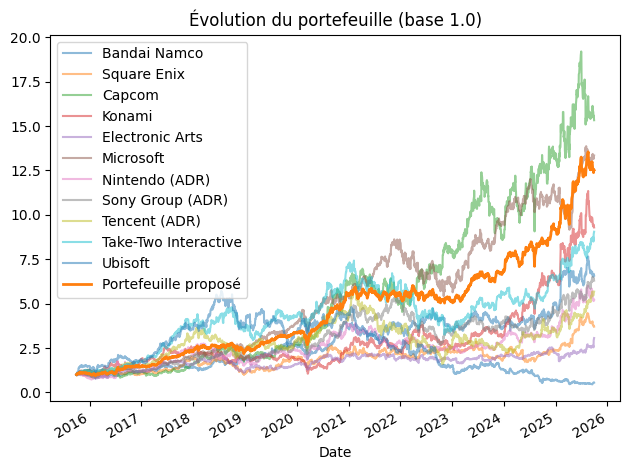


Souhaites-tu lancer une NOUVELLE simulation avec d’autres paramètres ? [o/N]: OUI

=== Nouvelle simulation ===


👋 Nouvelle configuration de portefeuille centrée sur Nintendo.
Réponds aux questions pour générer une nouvelle simulation.

Quel rendement annuel vises-tu ? [6%]: 10
Sur combien d'années envisages-tu d'investir ? [3]: 10
Quel pourcentage souhaites-tu allouer à Nintendo ? [30%]: 10

Téléchargement des données Yahoo Finance...

🧮 Allocation finale avec Nintendo fixé à 10%
name
Electronic Arts          -0.0 %
Ubisoft                  -0.0 %
Square Enix               0.0 %
Sony Group (ADR)         2.63 %
Tencent (ADR)            4.67 %
Nintendo (ADR)           10.0 %
Bandai Namco            11.53 %
Konami                  13.85 %
Take-Two Interactive     14.3 %
Capcom                  18.01 %
Microsoft                25.0 %
Name: w, dtype: object

🎯 Résultats estimés pour cette configuration :
  • Rendement annuel estimé : 29.07%
  • Volatilité annuelle estimée : 18.08%
  • Rat

<Figure size 1000x500 with 0 Axes>

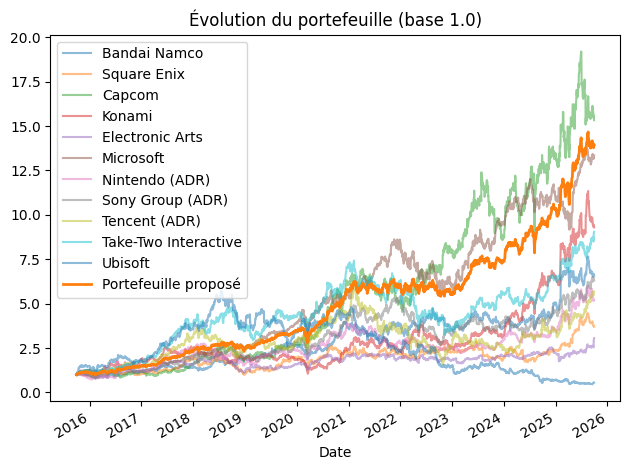


Souhaites-tu lancer une NOUVELLE simulation avec d’autres paramètres ? [o/N]: OUI

=== Nouvelle simulation ===


👋 Nouvelle configuration de portefeuille centrée sur Nintendo.
Réponds aux questions pour générer une nouvelle simulation.

Quel rendement annuel vises-tu ? [6%]: 5
Sur combien d'années envisages-tu d'investir ? [3]: 40
→ Entrer un entier entre 1 et 20.
Sur combien d'années envisages-tu d'investir ? [3]: 20
Quel pourcentage souhaites-tu allouer à Nintendo ? [30%]: 30

Téléchargement des données Yahoo Finance...

🧮 Allocation finale avec Nintendo fixé à 30%
name
Square Enix              -0.0 %
Electronic Arts           0.0 %
Sony Group (ADR)          0.0 %
Ubisoft                   0.0 %
Tencent (ADR)            0.53 %
Bandai Namco             9.21 %
Take-Two Interactive     9.35 %
Konami                  11.12 %
Capcom                  14.79 %
Microsoft                25.0 %
Nintendo (ADR)           30.0 %
Name: w, dtype: object

🎯 Résultats estimés pour cette configuration

<Figure size 1000x500 with 0 Axes>

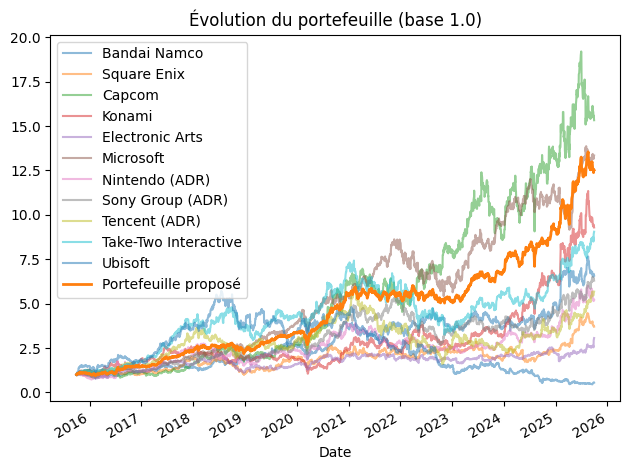


Souhaites-tu lancer une NOUVELLE simulation avec d’autres paramètres ? [o/N]: OUI

=== Nouvelle simulation ===


👋 Nouvelle configuration de portefeuille centrée sur Nintendo.
Réponds aux questions pour générer une nouvelle simulation.

Quel rendement annuel vises-tu ? [6%]: 40
→ Le pourcentage doit être entre 0% et 30%.
Quel rendement annuel vises-tu ? [6%]: 30
Sur combien d'années envisages-tu d'investir ? [3]: 10
Quel pourcentage souhaites-tu allouer à Nintendo ? [30%]: 30

Téléchargement des données Yahoo Finance...

🧮 Allocation finale avec Nintendo fixé à 30%
name
Square Enix              -0.0 %
Electronic Arts           0.0 %
Sony Group (ADR)          0.0 %
Ubisoft                   0.0 %
Tencent (ADR)            0.53 %
Bandai Namco             9.21 %
Take-Two Interactive     9.35 %
Konami                  11.12 %
Capcom                  14.79 %
Microsoft                25.0 %
Nintendo (ADR)           30.0 %
Name: w, dtype: object

🎯 Résultats estimés pour cette configuration :

<Figure size 1000x500 with 0 Axes>

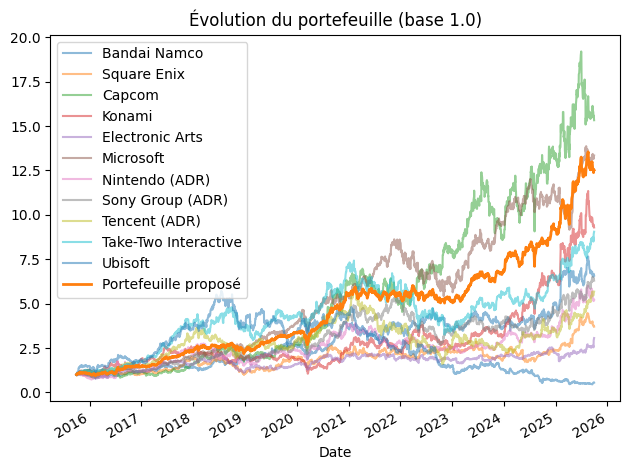

In [ ]:
# --------------------------------------------------------
# BOUCLE RÉPÉTÉE : exécuter plein de simulations d'affilée
# --------------------------------------------------------

while True:

    print("""
👋 Nouvelle configuration de portefeuille centrée sur Nintendo.
Réponds aux questions pour générer une nouvelle simulation.
""")

    # ======= QUESTIONS INVESTISSEUR =======
    target_return = ask_float_pct("Quel rendement annuel vises-tu ?", 0.06, 0.0, 0.3)
    horizon_years = ask_int("Sur combien d'années envisages-tu d'investir ?", 3, 1, 20)
    nintendo_weight = ask_float_pct(
        "Quel pourcentage souhaites-tu allouer à Nintendo ?",
        0.30,
        cons.min_center_weight,
        cons.max_center_weight,
    )

    # ======= DONNÉES =======
    print("\nTéléchargement des données Yahoo Finance...")
    universe = [NINTENDO] + DEFAULT_PEERS
    prices = download_prices(universe, START, END)
    returns = pct_returns(prices)

    tickers = list(returns.columns)
    center = NINTENDO if NINTENDO in tickers else tickers[0]

    mu_ann = returns.mean() * 252
    cov_ann = returns.cov() * 252

    # ======= OPTIMISATION =======
    weights = optimize_mv(
        mu_ann.loc[tickers],
        cov_ann.loc[tickers, tickers],
        tickers,
        center,
        cons,
        target_center_weight=nintendo_weight
    )

    port_rets = (returns[tickers] * weights).sum(axis=1)
    ann_ret, ann_vol, sharpe = ann_perf(port_rets)

    # ======= AFFICHAGE RESULTATS =======
    print("\n🧮 Allocation finale avec Nintendo fixé à", f"{nintendo_weight:.0%}")
    alloc_df = pd.DataFrame({"w": weights})
    alloc_df["name"] = alloc_df.index.map(lambda t: TICKER_NAME.get(t, t))
    alloc_df = alloc_df.sort_values("w")
    alloc_named = alloc_df.set_index("name")["w"]
    print((alloc_named * 100).round(2).astype(str) + " %")

    print(f"\n🎯 Résultats estimés pour cette configuration :")
    print(f"  • Rendement annuel estimé : {ann_ret:.2%}")
    print(f"  • Volatilité annuelle estimée : {ann_vol:.2%}")
    print(f"  • Ratio de Sharpe : {sharpe:.2f}")
    print(f"  • Horizon d'investissement déclaré : {horizon_years} ans")

    # ======= GRAPHIQUE =======
    growth_port = (1 + port_rets).cumprod()
    plt.figure(figsize=(10,5))
    (prices / prices.iloc[0]).rename(columns=lambda t: TICKER_NAME.get(t, t)).plot(alpha=0.5)
    growth_port.plot(label="Portefeuille proposé", linewidth=2)
    plt.legend()
    plt.title("Évolution du portefeuille (base 1.0)")
    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)

    # ======= QUESTION DE RELANCE =======
    rep = input("Souhaites-tu lancer une NOUVELLE simulation avec d’autres paramètres ? [o/N]: ").strip().lower()
    if rep not in ("o", "oui", "y", "yes"):
        print("👉 Fin des simulations.")
        break

    print("\n=== Nouvelle simulation ===\n")
